In [1]:
import zipfile
import datetime
import string
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.densenet import DenseNet121, preprocess_input
import matplotlib.pyplot as plt
import keras_ocr
from keras_ocr.detection import Detector
import numpy as np
import cv2
from keras_ocr.tools import read
#grab backgrounds and fonts
data_dir = '.'
alphabet = string.digits + string.ascii_letters + '!?. '

recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(alphabet=alphabet, cache_dir=data_dir)

backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)


Looking for ./fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|████████████████████| 2746/2746 [00:06<00:00, 450.38it/s]


Looking for ./backgrounds.zip


1000 images generated and saved to images.


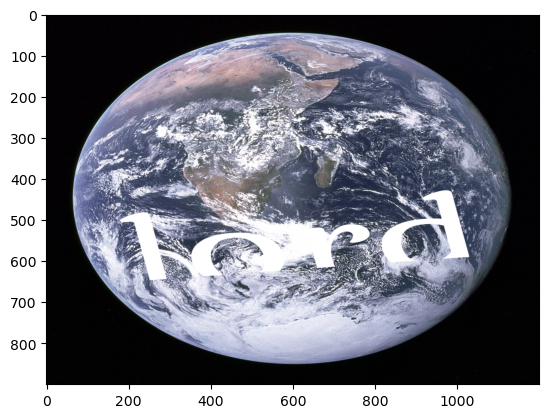

In [8]:
# Generate images for dataset
from PIL import Image, ImageDraw, ImageFont
import random
import os
import csv  
def calculate_luminance(color):
    # Calculate luminance based on the perceived brightness of RGB values
    return 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]

def get_contrast_color(background_color):
    # Choose black or white as the text color based on background luminance
    luminance = calculate_luminance(background_color)
    return (255, 255, 255) if luminance < 128 else (0, 0, 0)

# Set larger image dimensions
width, height = 1200, 900

# Number of images to generate
num_images = 1000

# List of words to include in the images
word_list = ["cat", "dog","potato","blue","red","green","size","lord"]


output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

font_paths = []
for font_path in fonts:
    font_paths.append(font_path)
background_paths = []
for background_path in backgrounds:
    background_paths.append(background_path)
reference_font_size = 1200
csv_file_path = "./images.csv"
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Image_Path', 'Selected_Word'])

    for i in range(num_images):
        # Create a blank image
        image = Image.new("RGB", (width, height), "white")

        background_path = random.choice(background_paths)
        background = Image.open(background_path)
        background = background.resize((width, height))  # Resize the background to match the desired dimensions

        # Create a blank image with the background
        image = Image.new("RGB", (width, height), "white")
        image.paste(background, (0, 0))
        draw = ImageDraw.Draw(image)



        # Randomly select font size and font path
        font_size = 400
        font_path = random.choice(font_paths)
        selected_word = random.choice(word_list)
        reference_font = ImageFont.truetype(font_path, reference_font_size)
        #reference_text_width, reference_text_height = draw.textsize(selected_word, font=reference_font)
        reference_text_bbox = draw.textbbox((0, 0), selected_word, font=reference_font)
        reference_text_width, reference_text_height = reference_text_bbox[2] - reference_text_bbox[0], reference_text_bbox[3] - reference_text_bbox[1]
        scaling_factor = reference_font_size / max(reference_text_width, reference_text_height)
        current_font_size = int(reference_font_size * scaling_factor)
        font = ImageFont.truetype(font_path, current_font_size)

        # Calculate the position to center the word
        #text_width, text_height = draw.textsize(selected_word, font)
        text_bbox = draw.textbbox((x, y), selected_word, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        x = (width - text_width) // 2
        y = (height - text_height) // 2

        # Randomly rotate and scale the text
        rotation_angle = random.uniform(-15, 15)
        scale_factor = random.uniform(0.8, 1.2)
        #X, y = font.getsize(selected_word)
        text_layer = Image.new("RGBA", (width, height), (255, 255, 255, 0))
        text_draw = ImageDraw.Draw(text_layer)

            # Get the background color at the text position
        background_color = image.getpixel((x, y))

        # Choose the contrasting text color based on background color luminance
        text_color = get_contrast_color(background_color)

        text_draw.text((x, y), selected_word, font=font, fill=text_color)

        rotated_text = text_layer.rotate(rotation_angle, resample=Image.BICUBIC, expand=True)
        scaled_text = rotated_text.resize((int(text_width * scale_factor), int(text_height * scale_factor)))
        x_centered = (width - scaled_text.width) // 2
        y_centered = (height - scaled_text.height) // 2
        image.paste(scaled_text, (x_centered, y_centered), scaled_text)


        # Save the generated image
        image_path = os.path.join(output_dir, f"generated_image_{i + 1}.png")
        plt.imshow(image)
        image.save(image_path)
        csv_writer.writerow([image_path, selected_word])


print(f"{num_images} images generated and saved to {output_dir}.")

In [9]:
# Preprocess data 
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Load data from the CSV file using pandas
csv_file_path = "./image_labels_no_rotation.csv"
df = pd.read_csv(csv_file_path)

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Create data generators for training, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Selected_Word',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Image_Path',
    y_col='Selected_Word',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical' 
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image_Path',
    y_col='Selected_Word',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical' 
)



Found 800 validated image filenames belonging to 8 classes.
Found 100 validated image filenames belonging to 8 classes.
Found 100 validated image filenames belonging to 8 classes.


In [10]:
# Create Convolutional NN
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.densenet import DenseNet121, preprocess_input


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) 

model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)


Epoch 1/10
25/25 [==============================] - 21s 833ms/step - loss: 2.1302 - accuracy: 0.1375 - val_loss: 2.0781 - val_accuracy: 0.1250
Epoch 2/10
25/25 [==============================] - 20s 794ms/step - loss: 2.0436 - accuracy: 0.1887 - val_loss: 2.0097 - val_accuracy: 0.2500
Epoch 3/10
25/25 [==============================] - 21s 826ms/step - loss: 1.8479 - accuracy: 0.3237 - val_loss: 1.7102 - val_accuracy: 0.3542
Epoch 4/10
25/25 [==============================] - 20s 793ms/step - loss: 1.3537 - accuracy: 0.5125 - val_loss: 1.0792 - val_accuracy: 0.6458
Epoch 5/10
25/25 [==============================] - 20s 784ms/step - loss: 0.8811 - accuracy: 0.7000 - val_loss: 0.9310 - val_accuracy: 0.6771
Epoch 6/10
25/25 [==============================] - 20s 787ms/step - loss: 0.6529 - accuracy: 0.7950 - val_loss: 0.8397 - val_accuracy: 0.6979
Epoch 7/10
25/25 [==============================] - 20s 795ms/step - loss: 0.4579 - accuracy: 0.8363 - val_loss: 0.7305 - val_accuracy: 0.7708

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

3/3 [==============================] - 2s 676ms/step - loss: 0.5316 - accuracy: 0.8333
Test Accuracy: 83.33%


In [67]:
# Use Detector from Keras OCR 
import matplotlib.pyplot as plt
import keras_ocr
from keras_ocr.detection import Detector
import numpy as np
import cv2
from keras_ocr.tools import read

test_image_path = "./test_images/red.jpg"



# Create a custom OCR pipeline with only the text detector
custom_pipeline = keras_ocr.pipeline.Pipeline()
images_not = ["https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg",
              'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg']

# image url
image_urls = [
    "./red5.png"
]

# read and reszize 
images = [cv2.resize(read(url), (500, 500)) for url in image_urls]

# Use the custom detector to detect text in the images
detections = custom_pipeline.detector.detect(images)


Looking for /Users/zacharyweisenbloom/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/zacharyweisenbloom/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 732ms/step


In [16]:
# Save image to file if needed 
import cv2

for i, detection in enumerate(detections):
    for j, text_info in enumerate(detection):
        # Extract coordinates
        x_min, y_min = map(int, text_info.min(axis=0))
        x_max, y_max = map(int, text_info.max(axis=0))


        text_region = images[i][y_min:y_max, x_min:x_max]
        cv2.imwrite(f"text_region_{i + 1}_{j + 1}.png", text_region)


In [69]:
# Grab image data from detection areas and make a prediction from detections
for i, detection in enumerate(detections):
    for j, text_info in enumerate(detection):
        # Extract coordinates
        x_min, y_min = map(int, text_info.min(axis=0))
        x_max, y_max = map(int, text_info.max(axis=0))

        # Crop and resize the text region
        text_region = cv2.resize(images[i][y_min:y_max, x_min:x_max], (128, 128))

        # Preprocess the image 
        preprocessed_text_region = preprocess_input(text_region)

        # Add a batch dimension
        preprocessed_text_region = np.expand_dims(preprocessed_text_region, axis=0)

        # Make predictions
        prediction = model.predict(preprocessed_text_region)

        # Find the index of the maximum value in the prediction array
        predicted_class_index = np.argmax(prediction)

        # Get the corresponding class label
        predicted_class_label = word_list[predicted_class_index]

        # Print the result
        print(f"Prediction for text region {i}, instance {j}: {predicted_class_index}")

1/1 [==============================] - 0s 16ms/step
Prediction for text region 0, instance 0: 6


In [68]:
# Make prediction from specific image
from keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Step 1: Preprocess the image
img_path = './images_no_rotation/generated_image_135.png'
img_path = './red5.png'
img = image.load_img(img_path, target_size=(128, 128))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values

# Step 2: Load the model

# Step 3: Make predictions
predictions = model.predict(img_array)
print(predictions)
# Step 4: Post-process predictions (example: get the class with the highest probability)
predicted_class = np.argmax(predictions)
print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 11ms/step
[[3.4950624e-04 1.0928289e-06 7.6138368e-03 5.0245080e-02 7.0973605e-01
  2.3174699e-01 1.7463992e-04 1.3283003e-04]]
Predicted Class: 4
